# Diamond Beach project

Honour Booth, Madeline Davis, Christy Chock
12/16/2022 OCN 682

Examining the concentrations of organic ultraviolet filters oxybenzone (BP3) and octocrylene (OC) at 'Diamond Beach' Oahu, Hawaiʻi.

This dataset was collected as clean and tidy. The flow is as follows:
1. undtidying and uncleaning the data
2. recleaning and retidying the data
3. initial data analysis
4. linear mixed models
5. visualization of the models

In conclusion, we found that the density of people per area had the most effect on concentrations of BP3 and OC.


In [1]:
# Loading packages used here
my_packages <- c("tidyverse", "lme4", "nlme", "readxl", "lmerTest", "dplyr", "ggplot2", "gridExtra", "cowplot")

In [123]:
lapply(my_packages, require, character.only = TRUE)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

# Cleaning and tidying

This includes untidying and retidying of our data set

In [3]:
# List excel sheets
combined_data <- excel_sheets("2_People_untidy_MD.xlsx") %>% map_df(~read_xlsx("2_People_untidy_MD.xlsx",.))
head(combined_data)

Moon,People_total,msq,Date,Time
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Muku,NA,8059.53,20220628,0
Muku,NA,8059.53,20220628,0
Muku,NA,8059.53,20220628,0
Muku,NA,8059.53,20220628,4
Muku,NA,8059.53,20220628,4
Muku,NA,8059.53,20220628,4


In [4]:
# Replace missing values with 0
combined_data[is.na(combined_data)] <- 0

In [5]:
# Divide People_total / msq to get total ppl_msq
combined_data$ppl_msq <- (combined_data$People_total / combined_data$msq)

In [6]:
# All BP3 and OC concentration ([UVF]) data from individual CSV files; str preview showing NA values
conc_muku <- data.frame(read.csv("conc_muku.csv"))
conc_ole <- data.frame(read.csv("conc_ole.csv"))
conc_hoku <- data.frame(read.csv("conc_hoku.csv"))
str(conc_muku)
str(conc_ole)
str(conc_hoku)

'data.frame':	30 obs. of  4 variables:
 $ Moon: chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time: int  0 0 0 4 4 4 8 8 8 9 ...
 $ BP3 : num  12.3 13.9 11.1 20 20.1 ...
 $ OC  : num  NA NA NA NA NA ...
'data.frame':	30 obs. of  4 variables:
 $ Moon: chr  "ʻOlekūkolu" "ʻOlekūkolu" "ʻOlekūkolu" "ʻOlekūkolu" ...
 $ Time: int  0 0 0 4 4 4 8 8 8 9 ...
 $ BP3 : num  21.2 21.5 19.3 20.3 21.7 ...
 $ OC  : num  NA NA NA 15.6 12.8 ...
'data.frame':	30 obs. of  4 variables:
 $ Moon: chr  "Hoku" "Hoku" "Hoku" "Hoku" ...
 $ Time: int  0 0 0 4 4 4 8 8 8 9 ...
 $ BP3 : num  36.9 35.1 35.9 36.6 37.1 ...
 $ OC  : num  87.4 73.7 71 84.2 109.1 ...


In [7]:
# Combine all [UVF] data to one data frame
conc <- rbind(conc_muku, conc_ole, conc_hoku)

In [8]:
# Replace NA values with 0; str preview
conc[is.na(conc)] <- 0
str(conc)

'data.frame':	90 obs. of  4 variables:
 $ Moon: chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time: int  0 0 0 4 4 4 8 8 8 9 ...
 $ BP3 : num  12.3 13.9 11.1 20 20.1 ...
 $ OC  : num  0 0 0 0 0 ...


In [9]:
# Combine [UVF] and pple from combined_data; head preview
conc_pple <- cbind(conc,combined_data)
head(conc_pple)

,Moon,Time,BP3,OC,Moon,People_total,msq,Date,Time,ppl_msq
,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Muku,0,12.34324,0,Muku,0,8059.53,20220628,0,0
2,Muku,0,13.92103,0,Muku,0,8059.53,20220628,0,0
3,Muku,0,11.11400,0,Muku,0,8059.53,20220628,0,0
4,Muku,4,20.03424,0,Muku,0,8059.53,20220628,4,0
5,Muku,4,20.05967,0,Muku,0,8059.53,20220628,4,0
6,Muku,4,18.89155,0,Muku,0,8059.53,20220628,4,0


In [10]:
# Remove duplicate columns, reorganize columns; head preview
conc_pple_2 <- conc_pple[,-5]
conc_pple_3 <- conc_pple_2[,-8]
conc_pple_4 <- conc_pple_3[,-6]
conc_pple_fin <- conc_pple_4 %>% relocate(Date, .after = Moon)
head(conc_pple_fin)

,Moon,Date,Time,BP3,OC,People_total,ppl_msq
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,Muku,20220628,0,12.34324,0,0,0
2,Muku,20220628,0,13.92103,0,0,0
3,Muku,20220628,0,11.11400,0,0,0
4,Muku,20220628,4,20.03424,0,0,0
5,Muku,20220628,4,20.05967,0,0,0
6,Muku,20220628,4,18.89155,0,0,0


In [11]:
# Kaimana_tide dataset
Diamond_data <- read.csv("Diamond_tide.csv")
str(Diamond_data)

'data.frame':	90 obs. of  6 variables:
 $ Date    : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon    : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time    : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide    : num  0.271 0.271 0.271 0.505 0.505 ...
 $ PreTide : num  0.24 0.24 0.24 0.54 0.54 0.54 0.54 0.54 0.54 -0.15 ...
 $ PostTide: num  0.54 0.54 0.54 -0.15 -0.15 -0.15 -0.15 -0.15 -0.15 2.28 ...


In [12]:
# Combining PreTide and PostTide columns into one
Diamond_data$PreTide_PostTide <- paste(Diamond_data$PreTide, Diamond_data$PostTide, sep="_")
str(Diamond_data)

'data.frame':	90 obs. of  7 variables:
 $ Date            : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon            : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time            : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide            : num  0.271 0.271 0.271 0.505 0.505 ...
 $ PreTide         : num  0.24 0.24 0.24 0.54 0.54 0.54 0.54 0.54 0.54 -0.15 ...
 $ PostTide        : num  0.54 0.54 0.54 -0.15 -0.15 -0.15 -0.15 -0.15 -0.15 2.28 ...
 $ PreTide_PostTide: chr  "0.24_0.54" "0.24_0.54" "0.24_0.54" "0.54_-0.15" ...


In [13]:
# Removing old columns
# Download this one as csv
tide <- Diamond_data[c("Date", "Moon", "Time", "Tide", "PreTide_PostTide")]
str(tide)

'data.frame':	90 obs. of  5 variables:
 $ Date            : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon            : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time            : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide            : num  0.271 0.271 0.271 0.505 0.505 ...
 $ PreTide_PostTide: chr  "0.24_0.54" "0.24_0.54" "0.24_0.54" "0.54_-0.15" ...


In [14]:
# Tidying up the data again (Cleaning)
tide[c('PreTide', 'PostTide')] <- str_split_fixed(tide$PreTide_PostTide, '_', 2)
str(tide)

'data.frame':	90 obs. of  7 variables:
 $ Date            : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon            : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time            : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide            : num  0.271 0.271 0.271 0.505 0.505 ...
 $ PreTide_PostTide: chr  "0.24_0.54" "0.24_0.54" "0.24_0.54" "0.54_-0.15" ...
 $ PreTide         : chr  "0.24" "0.24" "0.24" "0.54" ...
 $ PostTide        : chr  "0.54" "0.54" "0.54" "-0.15" ...


In [15]:
# Removing extra joint column (Cleaning)
tide_2 <- tide[c("Date", "Moon", "Time", "Tide", "PreTide", "PostTide")]
str(tide_2)

'data.frame':	90 obs. of  6 variables:
 $ Date    : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon    : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time    : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide    : num  0.271 0.271 0.271 0.505 0.505 ...
 $ PreTide : chr  "0.24" "0.24" "0.24" "0.54" ...
 $ PostTide: chr  "0.54" "0.54" "0.54" "-0.15" ...


In [16]:
# Convert Tide column from inches to meters
tide_2$Tide <- tide_2$Tide * 0.3048
str(tide_2)

'data.frame':	90 obs. of  6 variables:
 $ Date    : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon    : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time    : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide    : num  0.0826 0.0826 0.0826 0.1541 0.1541 ...
 $ PreTide : chr  "0.24" "0.24" "0.24" "0.54" ...
 $ PostTide: chr  "0.54" "0.54" "0.54" "-0.15" ...


In [17]:
# Changing PreTide and PostTide columns from character to double strings
tide_2$PreTide = as.double(tide_2$PreTide)
tide_2$PostTide = as.double(tide_2$PostTide)
str(tide_2)

'data.frame':	90 obs. of  6 variables:
 $ Date    : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon    : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time    : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide    : num  0.0826 0.0826 0.0826 0.1541 0.1541 ...
 $ PreTide : num  0.24 0.24 0.24 0.54 0.54 0.54 0.54 0.54 0.54 -0.15 ...
 $ PostTide: num  0.54 0.54 0.54 -0.15 -0.15 -0.15 -0.15 -0.15 -0.15 2.28 ...


In [18]:
# Convert PreTide and PostTide columns from inches to meters
tide_2$PreTide <- tide_2$PreTide * 0.3048
tide_2$PostTide <- tide_2$PostTide * 0.3048
str(tide_2)

'data.frame':	90 obs. of  6 variables:
 $ Date    : int  20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 20220628 ...
 $ Moon    : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Time    : num  0 0 0 4 4 4 8 8 8 9 ...
 $ Tide    : num  0.0826 0.0826 0.0826 0.1541 0.1541 ...
 $ PreTide : num  0.0732 0.0732 0.0732 0.1646 0.1646 ...
 $ PostTide: num  0.1646 0.1646 0.1646 -0.0457 -0.0457 ...


In [19]:
# Combine [UVF] and pple data with tidal data from tide_2
Diamond_all <- cbind(conc_pple_fin,tide_2)
head(Diamond_all)

,Moon,Date,Time,BP3,OC,People_total,ppl_msq,Date,Moon,Time,Tide,PreTide,PostTide
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Muku,20220628,0,12.34324,0,0,0,20220628,Muku,0,0.08264164,0.073152,0.164592
2,Muku,20220628,0,13.92103,0,0,0,20220628,Muku,0,0.08264164,0.073152,0.164592
3,Muku,20220628,0,11.11400,0,0,0,20220628,Muku,0,0.08264164,0.073152,0.164592
4,Muku,20220628,4,20.03424,0,0,0,20220628,Muku,4,0.15407579,0.164592,-0.045720
5,Muku,20220628,4,20.05967,0,0,0,20220628,Muku,4,0.15407579,0.164592,-0.045720
6,Muku,20220628,4,18.89155,0,0,0,20220628,Muku,4,0.15407579,0.164592,-0.045720


In [20]:
# Remove duplicate columns
Diamond_all_1 <- Diamond_all[,-10]
Diamond_all_2 <- Diamond_all_1[,-9]
Diamond_all_fin <- Diamond_all_2[,-8]

In [21]:
str(Diamond_all_fin)

'data.frame':	90 obs. of  10 variables:
 $ Moon        : chr  "Muku" "Muku" "Muku" "Muku" ...
 $ Date        : num  20220628 20220628 20220628 20220628 20220628 ...
 $ Time        : int  0 0 0 4 4 4 8 8 8 9 ...
 $ BP3         : num  12.3 13.9 11.1 20 20.1 ...
 $ OC          : num  0 0 0 0 0 ...
 $ People_total: num  0 0 0 0 0 0 9 9 9 11 ...
 $ ppl_msq     : num  0 0 0 0 0 ...
 $ Tide        : num  0.0826 0.0826 0.0826 0.1541 0.1541 ...
 $ PreTide     : num  0.0732 0.0732 0.0732 0.1646 0.1646 ...
 $ PostTide    : num  0.1646 0.1646 0.1646 -0.0457 -0.0457 ...


In [22]:
# Export finished tidy csv file
write.csv(Diamond_all_fin, "DiamondBeach_all.csv")

The cvs "DiamondBeach_all" was manually edited to include NA in BP3 and OC columns for the following times: 9,10,11,13,14,15,17,18,19. This csv file was renamed "DiamondBeach_all_fin" and used in code. NA is more appropriate that 0 as samples were not collected at these times, and 0 is not an accurate representation of UVF concentrations at these times. Data for other variables (people per area) at these times is required for visualization in exploratory data analysis.

# Exploratory data analysis

Here is our initial assessment of variations between the values.

In [124]:
### loading libraries
library(ggpubr)
library(tidyverse)
library(ggplot2)
library(gridExtra)

In [125]:
### DiamondBeach_all Dataset
DiamondBeach_data <- read.csv("DiamondBeach_all_fin.csv")

In [126]:
### Making Muku (New Moon)phase dataframe
Muku <-head(DiamondBeach_data, n=30)

In [127]:
### Making Muku (New Moon) and Number of People dataframe
Muku_people<-Muku[, c("Time","People_total")]

In [128]:
### Plotting Muku (New Moon) vs. Number of People
Muku.ppl <- ggplot(Muku_people, aes(Time, People_total)) + 
geom_bar(position = "dodge",
           stat = "summary",
           fun = "mean", fill = "blue")+
    labs(x ="Muku (New Moon)", y = "Number of People")

In [129]:
### Making 'Olekukolu (Half Moon) phase dataframe
Olekukolu <-DiamondBeach_data[31:60,] 

In [130]:
### Making 'Olekukolu (Half Moon) and Number of People dataframe
Olekukolu_people<-Olekukolu[, c("Time","People_total")]

In [131]:
### Plotting Olekukolu (Half Moon) vs. Number of People
Olekukolu.ppl <- ggplot(Olekukolu_people, aes(Time, People_total)) + 
geom_bar(position = "dodge",
           stat = "summary",
           fun = "mean", fill = "purple") +
    labs(x ="Olekukolu (Half Moon)", y = "")

In [132]:
### Making Hoku (Full Moon) phase dataframe
Hoku <-DiamondBeach_data[61:90,] 

In [133]:
### Making Hoku (Full Moon) and Number of People dataframe
Hoku_people<-Hoku[, c("Time","People_total")]

In [134]:
### Plotting Hoku (Full Moon) vs. Number of People
Hoku.ppl <- ggplot(Hoku_people, aes(Time, People_total)) + 
geom_bar(position = "dodge",
           stat = "summary",
           fun = "mean", fill = "pink") +
    labs(x ="Hoku (Full Moon)", y = "")      

In [135]:
### Making Muku (New Moon) and Tide Height (m) dataframe
Muku_tide<-Muku[, c("Time","Tide")]

In [136]:
### Plotting Muku (New Moon) vs. Tide Height (m)
Muku.tide <- ggplot(data = Muku_tide) +
    geom_line(aes(x = Time, y = Tide),color = "green", size = 2)+
    labs(x = "", y = "Tide Height (m)")

In [137]:
### Making 'Olekukolu (Half Moon) and Tide Height (m) dataframe
Olekukolu_tide<-Olekukolu[, c("Time","Tide")]

In [138]:
### Plotting 'Olekukolu (Half Moon) vs. Tide Height (m)
Olekukolu.tide <- ggplot(data = Olekukolu_tide) +
    geom_line(aes(x = Time, y = Tide),color = "orange", size = 2)+
    labs(x = "", y = "")

In [139]:
### Making Hoku (Full Moon) and Tide Height (m) dataframe
Hoku_tide<-Hoku[, c("Time","Tide")]

In [140]:
### Plotting Hoku (Full Moon) vs. Tide Height (m)
Hoku.tide <- ggplot(data = Hoku_tide) +
    geom_line(aes(x = Time, y = Tide),color = "yellow", size = 2)+
    labs(x = "", y = "") 

In [141]:
### Making Muku (New Moon) and BP3 dataframe
Muku_BP3<-Muku[, c("Time","BP3")]
Muku_BP3<-na.omit(Muku_BP3)

In [142]:
### Plotting Muku (New Moon) vs. BP3 replicates (mg/L)
Muku.vs.BP3.replicates <- ggplot(data = Muku_BP3) +
    geom_point(aes(x = Time, y = BP3),color = "red", size = 4)+
    labs(x = "", y = "BP3 (mg/L)")

In [143]:
### Making 'Olekukolu (Half Moon) and Tide Height (m) dataframe
Olekukolu_BP3<-Olekukolu[, c("Time","BP3")]
Olekukolu_BP3<-na.omit(Olekukolu_BP3)

In [144]:
### Plotting 'Olekukolu (Half Moon) vs. BP3 replicates (mg/L)
Olekukolu.vs.BP3.replicates <- ggplot(data = Olekukolu_BP3) +
    geom_point(aes(x = Time, y = BP3),color = "cyan", size = 4)+
    labs(x = "",y = "") 

In [145]:
### Making Hoku (Full Moon) and BP3 dataframe
Hoku_BP3<-Hoku[, c("Time","BP3")]
Hoku_BP3<-na.omit(Hoku_BP3)

In [146]:
### Plotting Hoku (Full Moon) vs. BP3 replicates (mg/L)
### Plotting Hoku (Full Moon) vs. BP3 replicates (mg/L)
Hoku.vs.BP3.replicates <- ggplot(data = Hoku_BP3) +
    geom_point(aes(x = Time, y = BP3),color = "brown", size = 4)+
    labs(x = "",y = "") 

In [147]:
### Making Muku (New Moon) and OC dataframe
Muku_OC<-Muku[, c("Time","OC")]
Muku_OC<-na.omit(Muku_OC)

In [148]:
### Plotting Muku (New Moon) vs. OC replicates (mg/L)
Muku.vs.OC.replicates <- ggplot(data = Muku_OC) +
    geom_point(aes(x = Time, y = OC),color = "gold", size = 4)+
    labs(x = "",y = "OC (mg/L)")

In [149]:
### Making 'Olekukolu (Half Moon) and OC dataframe
Olekukolu_OC<-Muku[, c("Time","OC")]
Olekukolu_OC<-na.omit(Olekukolu_OC)

In [150]:
### Plotting 'Olekukolu (Half Moon) vs. OC replicates (mg/L)
Olekukolu.vs.OC.replicates <- ggplot(data = Olekukolu_OC) +
    geom_point(aes(x = Time, y = OC),color = "dark green", size = 4)+
    labs(x = "",y = "") 

In [151]:
### Making Hoku (Full Moon) and OC dataframe
Hoku_OC<-Hoku[, c("Time","OC")]
Hoku_OC<-na.omit(Hoku_OC)

In [152]:
### Plotting Hoku (Full Moon) vs. OC replicates (mg/L)
Hoku.vs.OC.replicates <- ggplot(data = Hoku_OC) +
    geom_point(aes(x = Time, y = OC),color = "deepskyblue", size = 4)+
    labs(x = "",y = "") 

In [153]:
### Calculate the BP3 mean for Muku values
BP3_mean <- tapply(Muku_BP3$BP3,Muku_BP3$Time,mean)

In [154]:
#data.frame(BP3_mean for Muku (New Moon))
Time_data <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_data)
combined_BP3_mean <- cbind(Time,BP3_mean)
head(data.frame(combined_BP3_mean))

,Time,BP3_mean
,<dbl>,<dbl>
0,0,12.45942
4,4,19.66182
8,8,13.49042
12,12,17.60934
16,16,207.80959
20,20,16.18580


In [155]:
### Plotting Muku (New Moon) vs. BP3 mean (mg/L)
Muku.vs.BP3.mean <- qplot(Time, BP3_mean,  xlab = "Muku (New Moon)",
      ylab = "BP3 mean (mg/L)",
      main = "Muku (New Moon) vs. BP3 mean",
      size = I(4), color = "BP3 mean_Muku")

In [156]:
### Calculate the OC mean for 'Olekukolu (Half Moon) values
Olekukolu_mean <- tapply(Olekukolu_OC$OC,Olekukolu_OC$Time,mean)

In [157]:
#data.frame(BP3_mean for 'Olekukolu (Half Moon))
Time_BP3_mean <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_BP3_mean)
combined_Olekukolu_mean <- cbind(Time,Olekukolu_mean)
head(data.frame(combined_Olekukolu_mean))

,Time,Olekukolu_mean
,<dbl>,<dbl>
0,0,0.00000
4,4,0.00000
8,8,81.68983
12,12,64.44740
16,16,1243.36996
20,20,89.99121


In [158]:
### Plotting 'Olekukolu (Half Moon) vs. BP3 mean (mg/L)
Olekukolu.vs.BP3.mean <- qplot(Time, Olekukolu_mean,  xlab = "Olekukolu (Half Moon)",
      ylab = "BP3 mean (mg/L)",
      main = "Plot 8.3 (Olekukolu (Half Moon) vs. BP3 mean)",
      size = I(4), color = "BP3 mean_Olekukolu")

In [159]:
### Calculate the BP3 mean for Hoku (Full Moon) values
Hoku_mean <- tapply(Hoku_BP3$BP3,Hoku_BP3$Time,mean)

In [160]:
#data.frame(BP3_mean for Hoku (Full Moon))
#(0,4,8,9,10,11,12,13,14,15,16,17,18,19,20,24)
Time_BP3_mean <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_BP3_mean)
combined_Hoku_mean <- cbind(Time,Hoku_mean)
head(data.frame(combined_Hoku_mean))

,Time,Hoku_mean
,<dbl>,<dbl>
0,0,35.97264
4,4,36.14388
8,8,43.43318
12,12,36.28882
16,16,240.88296
20,20,39.15150


In [161]:
### Plotting Hoku (Full Moon) vs. BP3 mean (mg/L)
Hoku.vs.BP3.mean <- qplot(Time, Hoku_mean,  xlab = "Hoku (Full Moon)",
      ylab = "BP3 mean (mg/L)",
      main = "Plot 9.3 (Hoku (Full Moon) vs. BP3 mean)",
      size = I(4), color = "BP3 mean_Hoku")

In [162]:
### Calculate the OC mean for Muku (New Moon) values
OC_mean <- tapply(Muku_OC$OC,Muku_OC$Time,mean)

In [163]:
#data.frame(OC_mean) for Muku (New Moon) values
Time_OC_mean <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_OC_mean)
combined_OC_mean <- cbind(Time,OC_mean)
head(data.frame(combined_OC_mean))

,Time,OC_mean
,<dbl>,<dbl>
0,0,0.00000
4,4,0.00000
8,8,81.68983
12,12,64.44740
16,16,1243.36996
20,20,89.99121


In [164]:
### Plotting Muku (New Moon) vs. OC mean (mg/L)
Muku.vs.OC.mean <- qplot(Time, OC_mean,  xlab = "Muku (New Moon)",
      ylab = "OC mean (mg/L)",
      main = "Plot 7.4 (Muku (New Moon) vs. OC mean)",
      size = I(4), color = "OC mean_Muku")

In [165]:
### Calculate the OC mean for 'Olekukolu (Half Moon) values
OC_mean <- tapply(Olekukolu_OC$OC,Olekukolu_OC$Time,mean)

In [166]:
#data.frame(OC_mean) for 'Olekukolu (Half Moon) values
Time_OC_mean <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_OC_mean)
combined_OC_mean <- cbind(Time,OC_mean)
head(data.frame(combined_OC_mean))

,Time,OC_mean
,<dbl>,<dbl>
0,0,0.00000
4,4,0.00000
8,8,81.68983
12,12,64.44740
16,16,1243.36996
20,20,89.99121


In [167]:
### Plotting 'Olekukolu (Half Moon) vs. OC mean (mg/L)
Olekukolu.vs.OC.mean <- qplot(Time, OC_mean,  xlab = "'Olekukolu (Half Moon)",
      ylab = "OC mean (mg/L)",
      main = "'Olekukolu (Half Moon) vs. OC mean",
      size = I(4), color = "OC mean_'Olekukolu")

In [168]:
### Calculate the OC mean for Hoku (Full Moon) values
OC_mean <- tapply(Hoku_OC$OC,Hoku_OC$Time,mean)

In [169]:
#data.frame(OC_mean) for Hoku (Full Moon) values
Time_OC_mean <- c(0,4,8,12,16,20,24)
Time <- as.integer(Time_OC_mean)
combined_OC_mean <- cbind(Time,OC_mean)
head(data.frame(combined_OC_mean))

,Time,OC_mean
,<dbl>,<dbl>
0,0,77.35726
4,4,93.13995
8,8,87.05138
12,12,202.21011
16,16,846.08078
20,20,114.38566


In [170]:
### Plotting Hoku (Full Moon) vs. OC mean (mg/L)
Hoku.vs.OC.mean <- qplot(Time, OC_mean,  xlab = "Hoku (Full Moon)",
      ylab = "BP3 mean (mg/L)",
      main = "Hoku (Full Moon) vs. OC mean",
      size = I(4), color = "OC mean_Hoku")

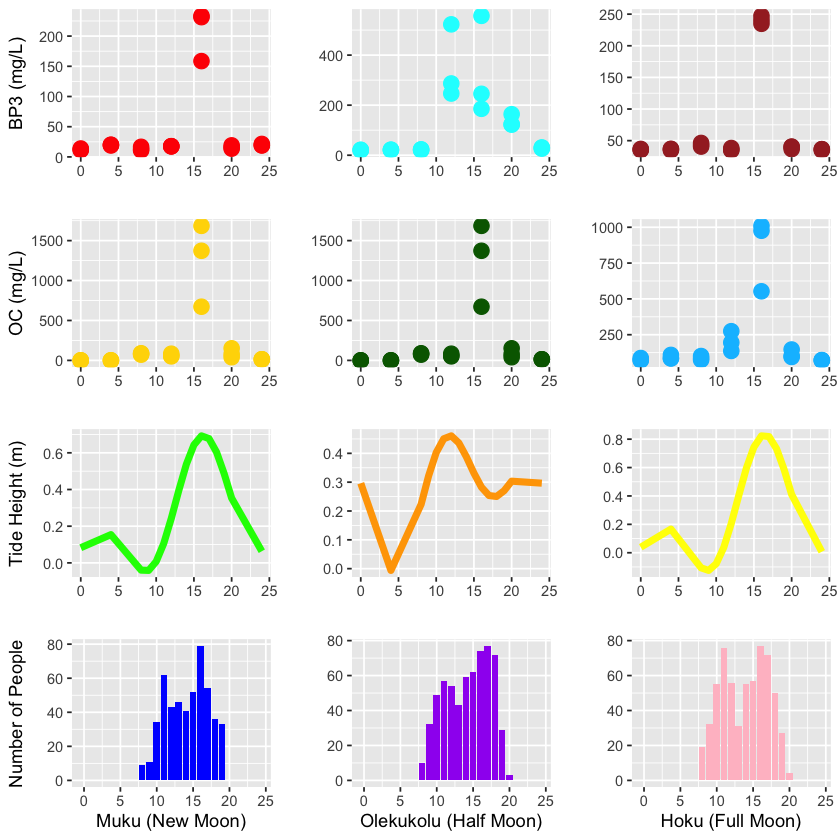

In [171]:
# Arranging Concentration, Tide, and People per area as tiled graphs 
plot_grid(Muku.vs.BP3.replicates, Olekukolu.vs.BP3.replicates, Hoku.vs.BP3.replicates,
          Muku.vs.OC.replicates, Olekukolu.vs.OC.replicates, Hoku.vs.OC.replicates,
    Muku.tide, Olekukolu.tide, Hoku.tide, 
         Muku.ppl, Olekukolu.ppl, Hoku.ppl, align = "hv", nrow = 4)

# Linear mixed model creation

This section uses the 'lme4' and 'lm' packages

In [172]:
# This is the start of mixed model creation

In [173]:
# The values need to be scaled for the appropriate model

In [174]:
Diamond_all_fin <- read.csv("DiamondBeach_all_fin.csv")
Diamond_all_fin<-na.omit(Diamond_all_fin)

In [175]:
Diamond_all_fin$ppl_msq_s <- scale(Diamond_all_fin$ppl_msq) 

In [176]:
Diamond_all_fin$Time_s <- scale(Diamond_all_fin$Time) 

In [177]:
Diamond_all_fin$Tide_s <- scale(Diamond_all_fin$Tide) 

In [178]:
Diamond_all_fin$Time <- as.numeric(Diamond_all_fin$Time)

In [179]:
Diamond_all_fin = Diamond_all_fin %>%
mutate(Moon_s = recode(Diamond_all_fin$Moon, 
                      "Muku" = 1, 
                      "Olekukolu" = 2, 
                      "Hoku" = 3))

Warning message:
“Unreplaced values treated as NA as `.x` is not compatible.
Please specify replacements exhaustively or supply `.default`.”


In [180]:
Diamond_all_fin

,X,Moon,Date,Time,BP3,OC,People_total,ppl_msq,Tide,PreTide,PostTide,ppl_msq_s,Time_s,Tide_s,Moon_s
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>
1,1,Muku,20220628,0,12.34324,0.000000,0,0.000000000,0.082641643,0.073152,0.164592,-0.7025836,-1.4880476,-0.67272253,1
2,2,Muku,20220628,0,13.92103,0.000000,0,0.000000000,0.082641643,0.073152,0.164592,-0.7025836,-1.4880476,-0.67272253,1
3,3,Muku,20220628,0,11.11400,0.000000,0,0.000000000,0.082641643,0.073152,0.164592,-0.7025836,-1.4880476,-0.67272253,1
4,4,Muku,20220628,4,20.03424,0.000000,0,0.000000000,0.154075790,0.164592,-0.045720,-0.7025836,-0.9920317,-0.35889923,1
5,5,Muku,20220628,4,20.05967,0.000000,0,0.000000000,0.154075790,0.164592,-0.045720,-0.7025836,-0.9920317,-0.35889923,1
6,6,Muku,20220628,4,18.89155,0.000000,0,0.000000000,0.154075790,0.164592,-0.045720,-0.7025836,-0.9920317,-0.35889923,1
7,7,Muku,20220628,8,10.77351,84.056500,9,0.001116690,-0.039571270,0.164592,-0.045720,-0.3923307,-0.4960159,-1.20962625,1
8,8,Muku,20220628,8,16.71569,89.256500,9,0.001116690,-0.039571270,0.164592,-0.045720,-0.3923307,-0.4960159,-1.20962625,1
9,9,Muku,20220628,8,12.98207,71.756500,9,0.001116690,-0.039571270,0.164592,-0.045720,-0.3923307,-0.4960159,-1.20962625,1


In [181]:
# Time of day effect on people m^2 using 'lm'
# P value shows effect on ppl_msq from time is significant
T_o_D_ppl_msq <- lm(ppl_msq ~ Time, data = Diamond_all_fin)
summary(T_o_D_ppl_msq)


Call:
lm(formula = ppl_msq ~ Time, data = Diamond_all_fin)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.003442 -0.002641 -0.001616  0.002806  0.006969 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) 1.616e-03  8.121e-04   1.990   0.0511 .
Time        7.607e-05  5.631e-05   1.351   0.1817  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003576 on 61 degrees of freedom
Multiple R-squared:  0.02905,	Adjusted R-squared:  0.01313 
F-statistic: 1.825 on 1 and 61 DF,  p-value: 0.1817


In [182]:
# Time of day effect on tide using 'lm'
# P value shows effect on ppl_msq from time is significant
T_o_D_Tide <- lm(Tide ~ Time_s, data = Diamond_all_fin)
summary(T_o_D_Tide)


Call:
lm(formula = Tide ~ Time_s, data = Diamond_all_fin)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33847 -0.08713 -0.00551  0.04405  0.55094 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.23577    0.02735   8.620  3.8e-12 ***
Time_s       0.07375    0.02757   2.675  0.00958 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2171 on 61 degrees of freedom
Multiple R-squared:  0.105,	Adjusted R-squared:  0.09031 
F-statistic: 7.155 on 1 and 61 DF,  p-value: 0.009583


In [183]:
# LMM 1
# Concentration of BP3 by time of day and ppl_msq
BP3.vs.time.ppl <- lmer(BP3 ~ Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3.vs.time.ppl)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ Time_s + ppl_msq_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 415.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1182 -0.2142  0.1490  0.4459  1.8095 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)   40.93   6.398  
 Residual             1863.89  43.173  
Number of obs: 42, groups:  Moon_s, 2

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)  55.1213     8.0526  0.9947   6.845   0.0932 .  
Time_s        5.4586     6.8119 38.0058   0.801   0.4279    
ppl_msq_s    55.7454     6.7765 38.1948   8.226 5.55e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) Time_s
Time_s     0.001       
ppl_msq_s -0.003 -0.168

In [184]:
# LMM2
# Concentration of OC by time of day and ppl_msq
OC.vs.time.ppl <- lmer(OC ~ Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC.vs.time.ppl)

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ Time_s + ppl_msq_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 548.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8149 -0.3018  0.0840  0.4037  3.6746 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)     0      0.0   
 Residual             56421    237.5   
Number of obs: 42, groups:  Moon_s, 2

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)   212.00      36.65  39.00   5.784 1.03e-06 ***
Time_s         29.06      37.48  39.00   0.775    0.443    
ppl_msq_s     289.78      37.26  39.00   7.777 1.88e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) Time_s
Time_s     0.001       
ppl_msq_s -0.004 -0.168
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')


In [185]:
# LMM3
# Concentration of BP3 off tide, time, and ppl_msq
BP3.vs.all <- lmer(BP3 ~ Tide_s + Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3.vs.all)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ Tide_s + Time_s + ppl_msq_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 392.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7763 -0.8153  0.0455  0.7389  1.6866 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)  132.4   11.51   
 Residual             1181.6   34.37   
Number of obs: 42, groups:  Moon_s, 2

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)   57.401      9.725  1.000   5.902  0.10685    
Tide_s        33.569      7.057 37.092   4.757 2.97e-05 ***
Time_s        -2.765      5.695 37.002  -0.486  0.63010    
ppl_msq_s     29.167      7.740 37.173   3.768  0.00057 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) Tide_s Time_s
Tide_s     0.049              
Time_s    -0.015 -0.305       
ppl_msq_s

In [186]:
# LMM4
# Concentration of OC off tide, time, and ppl_msq
OC.vs.all <- lmer(OC ~ Tide_s + Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC.vs.all)

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ Tide_s + Time_s + ppl_msq_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 530.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7533 -0.5041  0.1337  0.4121  3.8312 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)     0      0.0   
 Residual             46049    214.6   
Number of obs: 42, groups:  Moon_s, 2

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)  221.337     33.247  38.000   6.657 7.18e-08 ***
Tide_s       137.589     43.987  38.000   3.128 0.003372 ** 
Time_s        -4.837     35.550  38.000  -0.136 0.892480    
ppl_msq_s    181.956     48.181  38.000   3.777 0.000545 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) Tide_s Time_s
Tide_s     0.090              
Time_s    -0.027 -0.305       
ppl_m

In [187]:
# LMM5
# Concentration of BP3 versus ppl_msq and tide, where interactiosn with time are considered
BP3.vs.pple.tide.inttime <- lmer(BP3 ~ ppl_msq*Time_s + Tide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3.vs.pple.tide.inttime)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ ppl_msq * Time_s + Tide * Time_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 292.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7288 -0.5923 -0.0183  0.6359  1.5169 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept) 227.9    15.10   
 Residual             251.5    15.86   
Number of obs: 42, groups:  Moon_s, 2

Fixed effects:
                Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)       37.698     11.576     1.245   3.257  0.14908    
ppl_msq         3001.938   1098.102    35.048   2.734  0.00975 ** 
Time_s            -6.573      3.490    35.013  -1.883  0.06802 .  
Tide             -96.134     27.178    35.006  -3.537  0.00116 ** 
ppl_msq:Time_s 42701.114   3657.410    35.011  11.675 1.26e-13 ***
Time_s:Tide       67.646     25.050    35.033   2.700  0.01059 *  
---
Signif. codes:  0 ‘***

In [188]:
# LMM6
# Concentration of OC versus ppl_msq and tide, where interactiosn with time are considered
OC.vs.pple.tide.inttime <- lmer(OC ~ ppl_msq*Time_s + Tide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC.vs.pple.tide.inttime)

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ ppl_msq * Time_s + Tide * Time_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 456.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7797 -0.3114 -0.0262  0.1465  3.7327 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)     0      0.0   
 Residual             25807    160.6   
Number of obs: 42, groups:  Moon_s, 2

Fixed effects:
                Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)       122.70      45.31     36.00   2.708   0.0103 *  
ppl_msq         27226.92   11050.30     36.00   2.464   0.0187 *  
Time_s            -31.93      35.29     36.00  -0.905   0.3716    
Tide             -619.76     275.05     36.00  -2.253   0.0304 *  
ppl_msq:Time_s 204774.40   36990.73     36.00   5.536  2.9e-06 ***
Time_s:Tide       422.12     252.61     36.00   1.671   0.1034    
---
Signif. codes:  0 ‘***’

In [189]:
# LMM7
# Effect of tide, pretide and posttide (w/ time of day interaction) [BP3].
BP3_tide_pre_post_inttime <- lmer(BP3 ~ Tide*Time_s + PreTide*Time_s + PostTide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3_tide_pre_post_inttime)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ Tide * Time_s + PreTide * Time_s + PostTide * Time_s +  
    (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 277.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4883 -0.4339  0.0484  0.2010  3.1669 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept) 196.1    14.00   
 Residual             175.4    13.24   
Number of obs: 42, groups:  Moon_s, 2

Fixed effects:
                Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)       39.510     13.725    3.033   2.879  0.06277 .  
Tide             191.613     37.124   33.946   5.161 1.07e-05 ***
Time_s             3.709     19.924   33.924   0.186  0.85345    
PreTide         -116.256     80.141   34.000  -1.451  0.15604    
PostTide         -83.632     24.770   33.148  -3.376  0.00189 ** 
Tide:Time_s      273.360     30.353   33.381   9.006 1.88e-10 ***
Time_s:

In [190]:
# LMM8
# Effect of tide, pretide and posttide (w/ time of day interaction) [OC].
OC_tide_pre_post_inttime <- lmer(OC ~ Tide*Time_s + PreTide*Time_s + PostTide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC_tide_pre_post_inttime)

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ Tide * Time_s + PreTide * Time_s + PostTide * Time_s + (1 |  
    Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 458.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8376 -0.3091 -0.0079  0.1413  3.9793 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)     0      0.0   
 Residual             38683    196.7   
Number of obs: 42, groups:  Moon_s, 2

Fixed effects:
                Estimate Std. Error      df t value Pr(>|t|)   
(Intercept)        70.72     130.75   34.00   0.541  0.59210   
Tide              541.09     470.01   34.00   1.151  0.25767   
Time_s            -96.81     219.20   34.00  -0.442  0.66154   
PreTide          -465.88     952.68   34.00  -0.489  0.62797   
PostTide         -105.06     362.71   34.00  -0.290  0.77383   
Tide:Time_s      1266.12     433.09   34.00   2.923  0.00612 **
Time_s:PreTide   -271.

In [191]:
# LMM9
# Effect of pretide and posttide (w/ time of day interaction) on [BP3].
BP3_pre_post <- lmer(BP3 ~ PreTide*Time_s + PostTide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3_pre_post)

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ PreTide * Time_s + PostTide * Time_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 342.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6507 -0.5732 -0.2044  0.6089  2.0833 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)   0.0     0.00   
 Residual             671.4    25.91   
Number of obs: 42, groups:  Moon_s, 2

Fixed effects:
                Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)        55.25      16.75   36.00   3.299  0.00219 ** 
PreTide          -527.27     115.04   36.00  -4.583 5.33e-05 ***
Time_s           -135.73      16.33   36.00  -8.310 6.82e-10 ***
PostTide          -67.71      40.14   36.00  -1.687  0.10031    
PreTide:Time_s    648.09     114.66   36.00   5.652 2.03e-06 ***
Time_s:PostTide   665.00      60.08   36.00  11.068 3.86e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘*

In [192]:
# LMM10
# Effect of pretide and posttide (w/ time of day interaction) on [OC].
OC_pre_post <- lmer(OC ~ PreTide*Time_s + PostTide*Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC_pre_post)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ PreTide * Time_s + PostTide * Time_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 494.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2098 -0.5891 -0.0680  0.4235  3.8552 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)  7389     85.96  
 Residual             44447    210.82  
Number of obs: 42, groups:  Moon_s, 2

Fixed effects:
                Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)       173.61     156.91    13.54   1.106  0.28780    
PreTide         -2362.07    1017.58    34.97  -2.321  0.02622 *  
Time_s           -634.38     143.96    35.12  -4.407 9.43e-05 ***
PostTide         -204.67     351.40    35.38  -0.582  0.56396    
PreTide:Time_s   3003.88    1018.33    34.79   2.950  0.00565 ** 
Time_s:PostTide  3084.99     526.98    35.32   5.854 1.16e-06 ***
---
Signif. codes:  0 ‘***’ 0.

In [193]:
# LMM11
# Effect of tide, pretide and posttide [BP3], time completely excluded; 
# tidal heights are discrete values that occur at differnt times of day, therefore . 
BP3_tide_pre_post <- lmer(BP3 ~ Tide + PreTide + PostTide + (1|Moon_s), data = Diamond_all_fin)
summary(BP3_tide_pre_post)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ Tide + PreTide + PostTide + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 364.6

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.64874 -0.50445 -0.00069  0.33646  2.14437 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept) 203.5    14.26   
 Residual             693.7    26.34   
Number of obs: 42, groups:  Moon_s, 2

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)   33.811     12.235    1.599   2.763 0.139419    
Tide         302.773     24.729   37.000  12.243  1.4e-14 ***
PreTide     -155.377     22.416   37.003  -6.932  3.5e-08 ***
PostTide     -92.400     22.903   37.000  -4.034 0.000263 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr) Tide   PreTid
Tide      0.067              
PreTide  -0.352 -0.582  

In [194]:
# LMM12
# Effect of tide, pretide and posttide [OC], time completely excluded; 
# tidal heights are discrete values that occur at differnt times of day, therefore . 
OC_tide_pre_post <- lmer(OC ~ Tide + PreTide + PostTide + (1|Moon_s), data = Diamond_all_fin)
summary(OC_tide_pre_post)

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ Tide + PreTide + PostTide + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 523

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1620 -0.5200 -0.0980  0.2018  3.9055 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)     0      0.0   
 Residual             47146    217.1   
Number of obs: 42, groups:  Moon_s, 2

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)    75.82      57.09   38.00   1.328  0.19209    
Tide         1343.04     203.87   38.00   6.588 8.93e-08 ***
PreTide      -616.18     184.78   38.00  -3.335  0.00191 ** 
PostTide     -283.76     188.81   38.00  -1.503  0.14114    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr) Tide   PreTid
Tide      0.118              
PreTide  -0.622 -0.582       
PostTide -0.

In [195]:
# LMM13
# Effect of tide, pretide and posttide [BP3], time completely excluded; 
# tidal heights are discrete values that occur at differnt times of day, therefore . 
BP3_tide_all <- lmer(BP3 ~ Tide + PreTide + PostTide +Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(BP3_tide_all)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: BP3 ~ Tide + PreTide + PostTide + Time_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 356.6

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.56079 -0.56206 -0.09308  0.37028  2.13918 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept) 203.3    14.26   
 Residual             654.7    25.59   
Number of obs: 42, groups:  Moon_s, 2

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)   39.494     12.528    1.787   3.152   0.1010    
Tide         304.239     24.038   36.000  12.657 8.08e-15 ***
PreTide     -172.695     23.824   36.003  -7.249 1.55e-08 ***
PostTide    -106.524     23.603   36.000  -4.513 6.58e-05 ***
Time_s         8.271      4.613   36.000   1.793   0.0814 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Int

In [196]:
# LMM14
# Effect of tide, pretide and posttide [BP3], time completely excluded; 
# tidal heights are discrete values that occur at differnt times of day, therefore . 
OC_tide_all <- lmer(OC ~ Tide + PreTide + PostTide +Time_s + (1|Moon_s), data = Diamond_all_fin)
summary(OC_tide_all)

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: OC ~ Tide + PreTide + PostTide + Time_s + (1 | Moon_s)
   Data: Diamond_all_fin

REML criterion at convergence: 513.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1794 -0.5588 -0.1135  0.2059  3.8578 

Random effects:
 Groups   Name        Variance Std.Dev.
 Moon_s   (Intercept)     0      0     
 Residual             47513    218     
Number of obs: 42, groups:  Moon_s, 2

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)    98.52      63.36   37.00   1.555  0.12846    
Tide         1348.89     204.78   37.00   6.587 1.01e-07 ***
PreTide      -685.37     202.93   37.00  -3.377  0.00173 ** 
PostTide     -340.17     201.07   37.00  -1.692  0.09909 .  
Time_s         33.04      39.30   37.00   0.841  0.40597    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr) Tide   PreTid 

# Visualization

This code is based on https://lmudge13.github.io/sample_code/mixed_effects.html.
The packages used include cowplot, sjPlot, sjmisc, effect and sjstats.

In [197]:
# Loading packages used here

In [198]:
my_packages_2 <- c("cowplot", "sjPlot", "sjmisc", "effect", "sjstats")

In [199]:
lapply(my_packages, require, character.only = TRUE)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

In [200]:
# Viz of LMM 1
# Concentration of BP3 by time of day and ppl_msq
BP3.vs.time.ppl <- lmer(BP3 ~ Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)

In [201]:
sjPlot::tab_model(BP3.vs.time.ppl, 
                  show.re.var= TRUE, 
                  pred.labels =c("(Intercept)", "Time of day", "People per area (m^2)"), 
                  dv.labels= "Effects of People and Time of Day on Oxybenzone Concentrations")

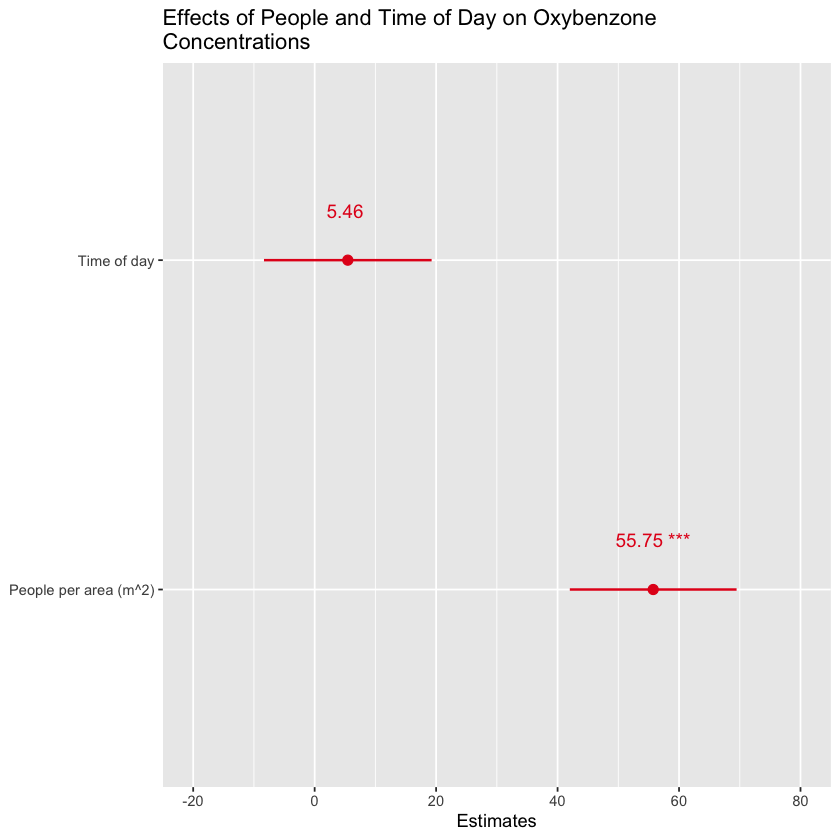

In [202]:
sjPlot::plot_model(BP3.vs.time.ppl, 
                   axis.labels=c("People per area (m^2)", "Time of day"),
                   show.values=TRUE, show.p=TRUE,
                   title="Effects of People and Time of Day on Oxybenzone Concentrations")

In [204]:
BP3effects_ppl <- effects::effect(term= "ppl_msq_s", mod= BP3.vs.time.ppl)
#summary(BP3effects_ppl)

Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictors Time_s, ppl_msq_s are one-column matrices that were converted to vectors”


In [205]:
BP3_ppl <- as.data.frame(BP3effects_ppl)

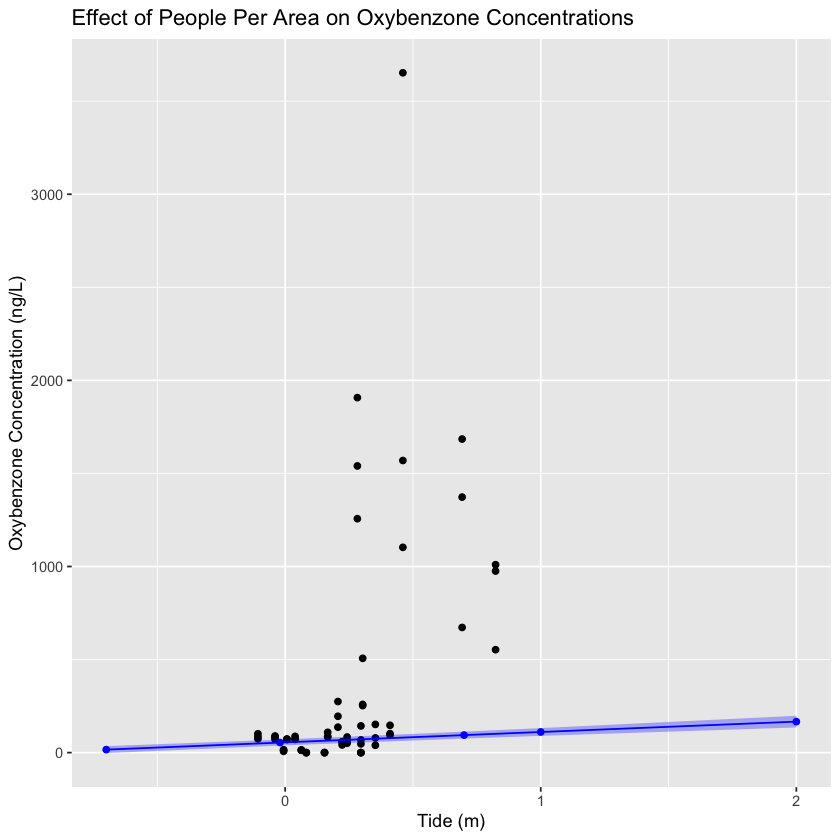

In [206]:
BP3ppl_plot <- ggplot() + 
  #2
geom_point(data=subset(Diamond_all_fin), aes(Tide, OC)) + 
  #3
  geom_point(data= BP3_ppl, aes(x=ppl_msq_s, y=fit), color="blue") +
  #4
  geom_line(data= BP3_ppl, aes(x=ppl_msq_s, y=fit), color="blue") +
  #5
  geom_ribbon(data= BP3_ppl, aes(x=ppl_msq_s, ymin=lower, ymax=upper), alpha= 0.3, fill="blue") +
  #6
  labs(x="Tide (m)", y="Oxybenzone Concentration (ng/L)") +
  ggtitle("Effect of People Per Area on Oxybenzone Concentrations")

BP3ppl_plot

In [207]:
# LMM2
# Concentration of OC by time of day and ppl_msq
#OC.vs.time.ppl <- lmer(OC ~ Time_s + ppl_msq_s + (1|Moon_s), data = Diamond_all_fin)

In [208]:
sjPlot::tab_model(OC.vs.time.ppl, 
                  show.re.var= TRUE, 
                  pred.labels =c("(Intercept)", "Time of day", "People per area (m^2)"), 
                  dv.labels= "Effects of People and Time of Day on Octocrylene Concentrations")

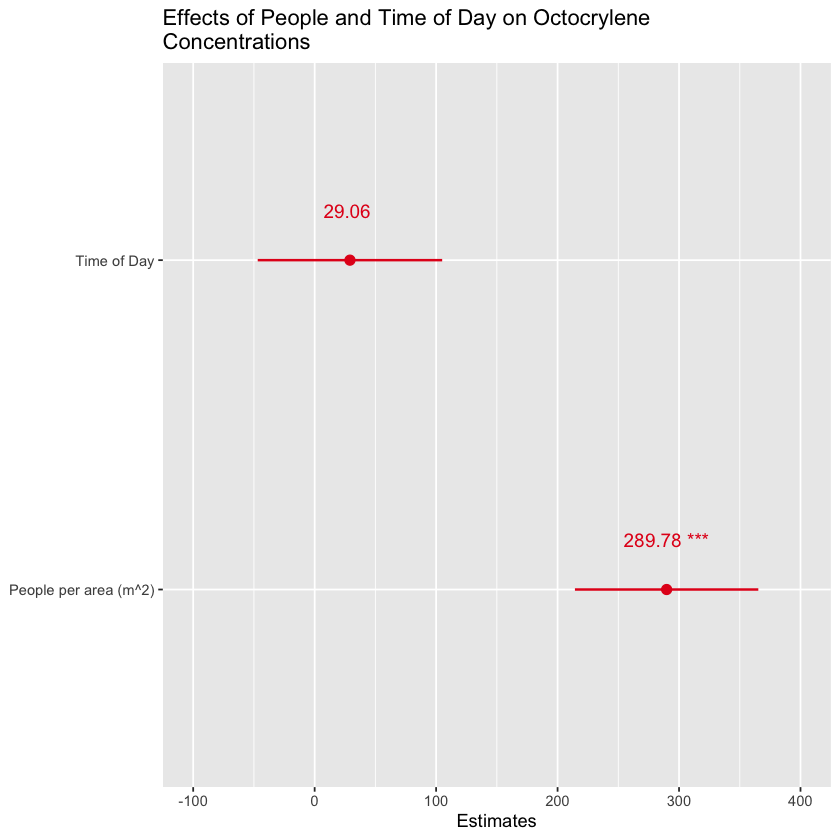

In [209]:
sjPlot::plot_model(OC.vs.time.ppl, 
                   axis.labels=c("People per area (m^2)", "Time of Day"),
                   show.values=TRUE, show.p=TRUE,
                   title="Effects of People and Time of Day on Octocrylene Concentrations")

In [210]:
OCeffects_ppl <- effects::effect(term= "ppl_msq_s", mod= OC.vs.time.ppl)
#summary(BP3effects_ppl)

Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictors Time_s, ppl_msq_s are one-column matrices that were converted to vectors”


In [211]:
OC_ppl <- as.data.frame(OCeffects_ppl)

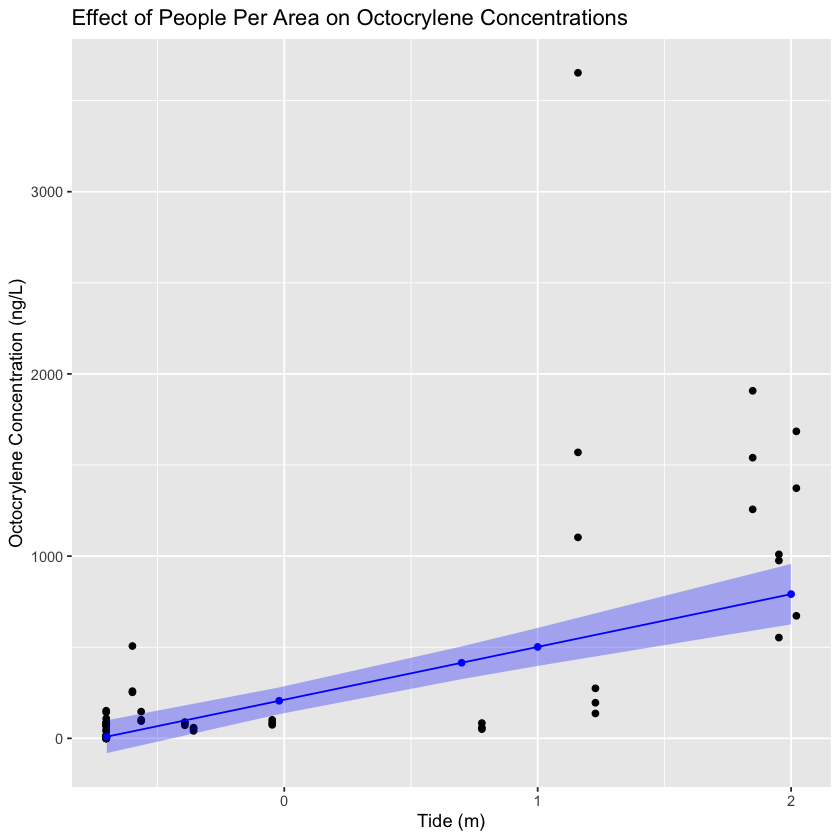

In [212]:
OCppl_plot <- ggplot() + 
  #2
geom_point(data=subset(Diamond_all_fin), aes(ppl_msq_s, OC)) + 
  #3
  geom_point(data= OC_ppl, aes(x=ppl_msq_s, y=fit), color="blue") +
  #4
  geom_line(data= OC_ppl, aes(x=ppl_msq_s, y=fit), color="blue") +
  #5
  geom_ribbon(data= OC_ppl, aes(x=ppl_msq_s, ymin=lower, ymax=upper), alpha= 0.3, fill="blue") +
  #6
  labs(x="Tide (m)", y="Octocrylene Concentration (ng/L)") +
  ggtitle("Effect of People Per Area on Octocrylene Concentrations")

OCppl_plot

In [213]:
# LMM11
# Effect of tide, pretide and posttide [BP3], time completely excluded. 
#BP3_tide_pre_post <- lmer(BP3 ~ Tide + PreTide + PostTide + (1|Moon_s), data = Diamond_all_fin)


In [214]:
sjPlot::tab_model(BP3_tide_pre_post, 
                  show.re.var= TRUE, 
                  pred.labels =c("(Intercept)","Tide", "Pre Tide", "Post Tide"), 
                  dv.labels= "Effects of Tide, PreTide and PostTide on Oxybenzone Concentrations")

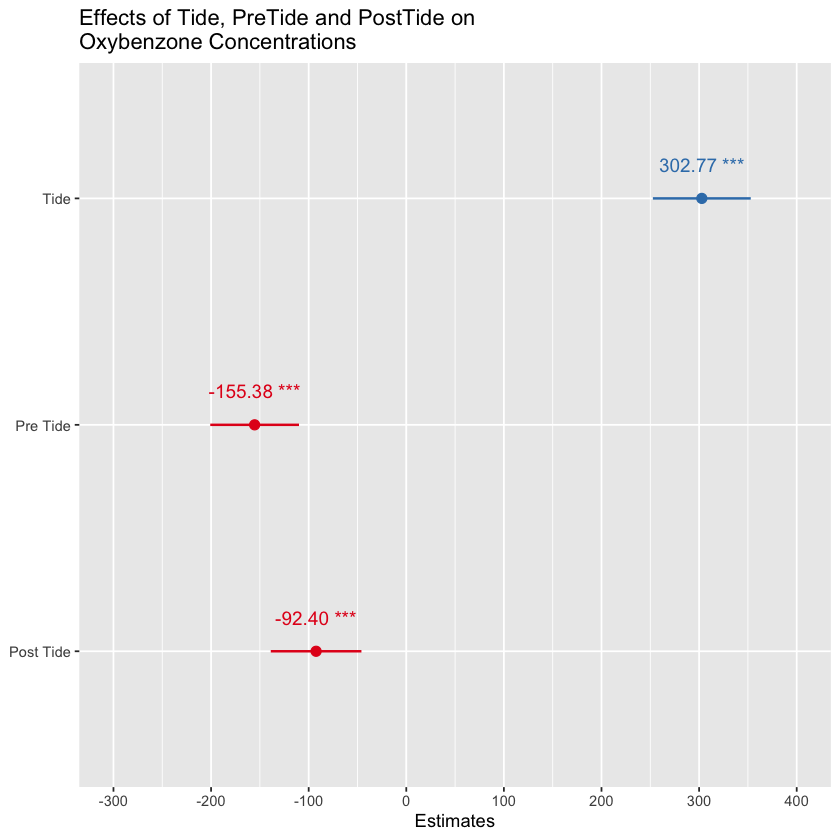

In [215]:
sjPlot::plot_model(BP3_tide_pre_post, 
                   axis.labels=c("Post Tide", "Pre Tide", "Tide"),
                   show.values=TRUE, show.p=TRUE,
                   title="Effects of Tide, PreTide and PostTide on Oxybenzone Concentrations")

In [216]:
BP3effects_tide <- effects::effect(term= "Tide", mod= BP3_tide_pre_post)
#summary(BP3effects_tide)

In [217]:
BP3_tide <- as.data.frame(BP3effects_tide)

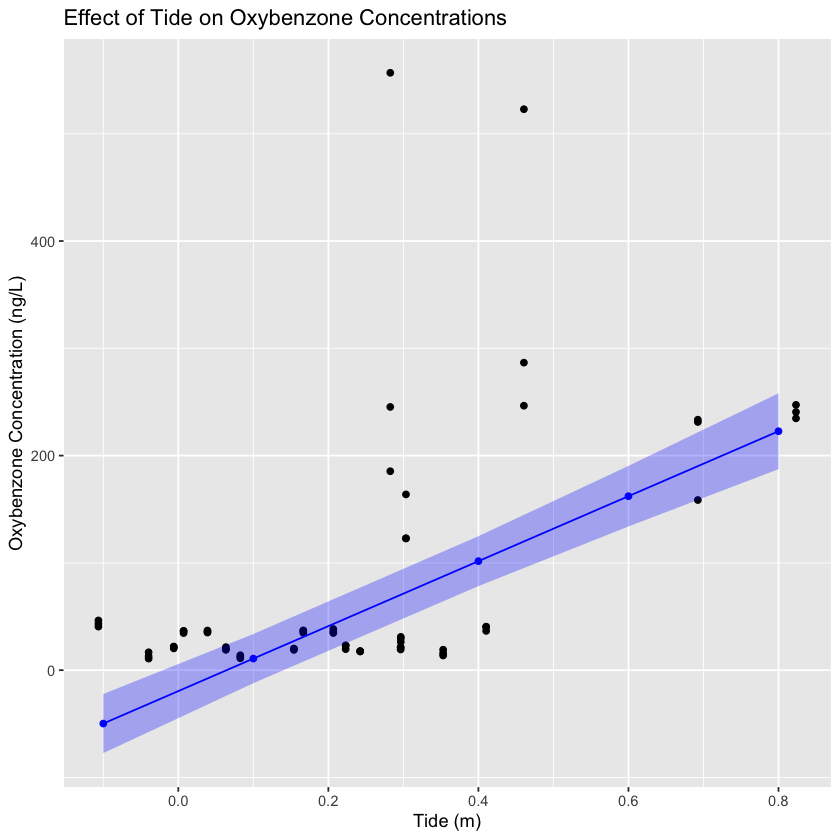

In [218]:
BP3tide_plot <- ggplot() + 
  #2
geom_point(data=subset(Diamond_all_fin), aes(Tide, BP3)) + 
  #3
  geom_point(data= BP3_tide, aes(x=Tide, y=fit), color="blue") +
  #4
  geom_line(data= BP3_tide, aes(x=Tide, y=fit), color="blue") +
  #5
  geom_ribbon(data= BP3_tide, aes(x=Tide, ymin=lower, ymax=upper), alpha= 0.3, fill="blue") +
  #6
  labs(x="Tide (m)", y="Oxybenzone Concentration (ng/L)") +
  ggtitle("Effect of Tide on Oxybenzone Concentrations")

BP3tide_plot

In [219]:
# LMM12
# Effect of tide, pretide and posttide [OC], time completely excluded. 
#OC_tide_pre_post <- lmer(OC ~ Tide + PreTide + PostTide + (1|Moon_s), data = Diamond_all_fin)

In [220]:
sjPlot::tab_model(OC_tide_pre_post, 
                  show.re.var= TRUE, 
                  pred.labels =c("(Intercept)","Tide", "Pre Tide", "Post Tide"), 
                  dv.labels= "Effects of Tide, PreTide and PostTide on Octocrylene Concentrations")

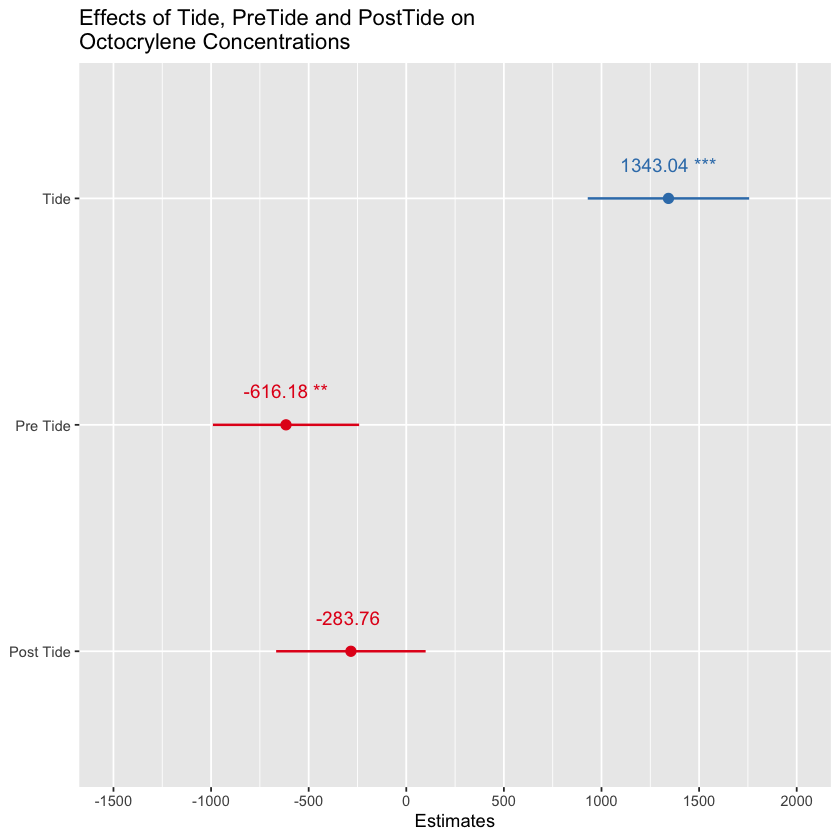

In [221]:
sjPlot::plot_model(OC_tide_pre_post, 
                   axis.labels=c("Post Tide", "Pre Tide", "Tide"),
                   show.values=TRUE, show.p=TRUE,
                   title="Effects of Tide, PreTide and PostTide on Octocrylene Concentrations")

In [222]:
OCeffects_tide <- effects::effect(term= "Tide", mod= OC_tide_pre_post)
#summary(OCeffects_tide)

In [223]:
OC_tide <- as.data.frame(OCeffects_tide)

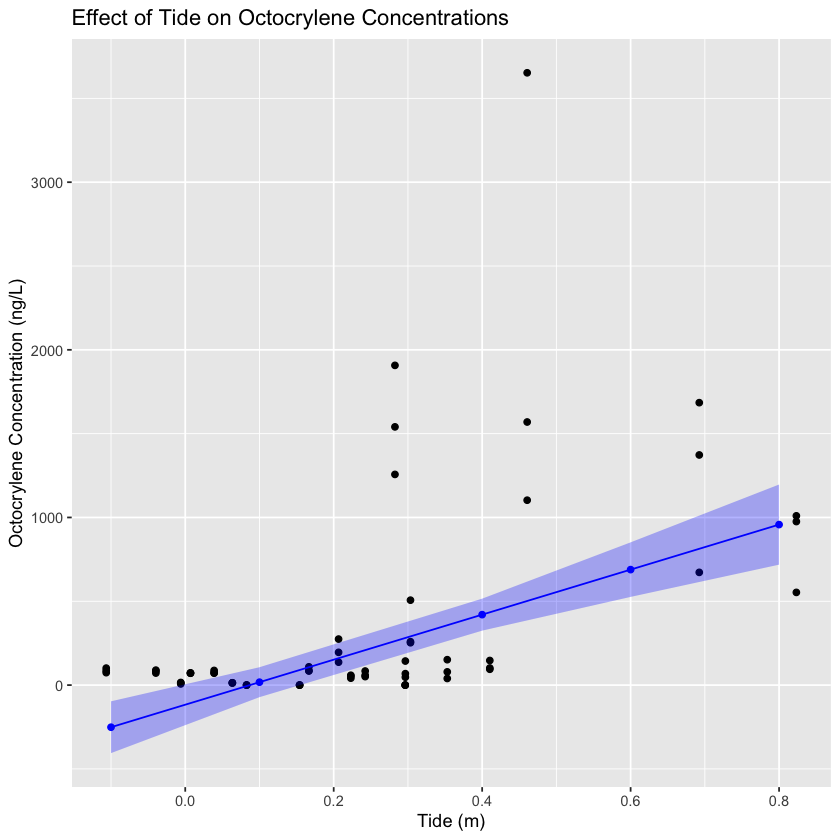

In [224]:
OCtide_plot <- ggplot() + 
  #2
geom_point(data=subset(Diamond_all_fin), aes(Tide, OC)) + 
  #3
  geom_point(data= OC_tide, aes(x=Tide, y=fit), color="blue") +
  #4
  geom_line(data= OC_tide, aes(x=Tide, y=fit), color="blue") +
  #5
  geom_ribbon(data= OC_tide, aes(x=Tide, ymin=lower, ymax=upper), alpha= 0.3, fill="blue") +
  #6
  labs(x="Tide (m)", y="Octocrylene Concentration (ng/L)") +
  ggtitle("Effect of Tide on Octocrylene Concentrations")

OCtide_plot